# Exploratory Data Analysis

#### Oviya Adhan

#### DATASCI 207 Machine Learning

#### Professor Cornelia Paulik

Context: The data was pre-processed to merge three datasets together with the chosen variables. See pre-processing step for details. Due to this merge, there are some crash records with no matching records for injured witness/passengers or involved parties. To mitigate these missing variables, rows with NaN values in the features from these secondary datasets will be removed. The NaN value for injury extent will not be removed and instead coverted to 'No Injury' to ensure we include any crashes that did not result in any injuries, but have data from the secondary datasets.

The strategy for EDA is as follows:
1.   Treat NaN values
*   Filter out rows with NaN values in feature columns
*   Convert NaN values in the label column (ExtentOfInjuryCode)
2.   Split data into train, validation, and test sets
3.   Normalize numerical variables across all data based on train dataset
4.   Conduct exploratory analysis on the train dataset
5.   Encode categorical variables with one-hot encoding (*a suggestion is included, but not finalized*)



In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from sklearn.model_selection import train_test_split
from itertools import chain
import ast
from itertools import combinations
from collections import Counter, defaultdict

In [ ]:
# Connect to GitHub Repo
from getpass import getpass

# Step 1: Enter token securely
token = getpass('Enter your GitHub token: ')

# Step 2: Build the full URL
repo_owner = "christinesako-berk"
repo_name = "ds_207_final_project"
repo_url = f"https://{token}@github.com/{repo_owner}/{repo_name}.git"

# Clone repo
!git clone "{repo_url}"

In [ ]:
%cd /content/ds_207_final_project/data/processed

/content/ds_207_final_project/data/processed


In [ ]:
!ls

ds_207_final_project  final_merged_2024.csv  final_merged_2025.csv


## 1. Filter out Rows with NaN Values


*   Completely remove rows with NaN value in feature columns
*   Convert remaining rows with NaN value in label column



In [ ]:
# Load data
initial_2024 = pd.read_csv('final_merged_2024.csv')
initial_2025 = pd.read_csv('final_merged_2025.csv')

*Note: In the next step, I will check the unique values of all the data to ensure format integrity. This information will not be used to inform the model beyond removing rows with NaN values.*

In [36]:
pd.set_option('display.max_colwidth', None)  # Show full content in a column
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.width', None)         # Don't wrap lines early
pd.set_option('display.max_rows', None)      # Optional: show all rows too

In [37]:
# Initialize list to hold extracted information
rows_2024 = []

# Iterate through columns and extract information
for col in initial_2024.columns:
    row = {
        'Column Name': col,                                 # Name of column
        'Data Type': initial_2024[col].dtype,                  # Check data type
        'NaN Count': initial_2024[col].isna().sum(),           # Check NaN counts
        'Unique Values': initial_2024[col].unique().tolist()   # Check unique values
    }

    rows_2024.append(row)

# Convert list to DF and view
nan_summary_2024 = pd.DataFrame(rows_2024)
print("\nTraining and Validation Dataset Summary:") # Print custom summary
nan_summary_2024


Training and Validation Dataset Summary:


Column Name Data Type  NaN Count  \
0                        CollisionId     int64          0   
1           CollisionTypeDescription    object          0   
2                   IsHighwayRelated      bool          0   
3                           Weather1    object          0   
4                     RoadCondition1    object          0   
5                LightingDescription    object          0   
6                 ExtentOfInjuryCode    object     293729   
7        MovementPrecCollDescription    object     133951   
8                  AirbagDescription    object     133951   
9         SafetyEquipmentDescription    object     133951   
10  SobrietyDrugPhysicalDescription1    object     133951   
11                SpecialInformation    object     133951   
12                        SpeedLimit   float64     133951   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [38]:
# On test data
# Initialize list to hold extracted information
rows_2025 = []

# Iterate through columns and extract information
for col in initial_2025.columns:
    row = {
        'Column Name': col,                                 # Name of column
        'Data Type': initial_2025[col].dtype,                  # Check data type
        'NaN Count': initial_2025[col].isna().sum(),           # Check NaN counts
        'Unique Values': initial_2025[col].unique().tolist()   # Check unique values
    }

    rows_2025.append(row)

# Convert list to DF and view
nan_summary_2025 = pd.DataFrame(rows_2025)
print("\nTest Dataset Summary:") # Print custom summary
nan_summary_2025


Test Dataset Summary:


Column Name Data Type  NaN Count  \
0                        CollisionId     int64          0   
1           CollisionTypeDescription    object          0   
2                   IsHighwayRelated      bool          0   
3                           Weather1    object          0   
4                     RoadCondition1    object          0   
5                LightingDescription    object          0   
6                 ExtentOfInjuryCode    object      98942   
7        MovementPrecCollDescription    object      35774   
8                  AirbagDescription    object      35774   
9         SafetyEquipmentDescription    object      35774   
10  SobrietyDrugPhysicalDescription1    object      35774   
11                SpecialInformation    object      35774   
12                        SpeedLimit   float64      35774   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Features with NaN values:
*   ExtentOfInjuryCode (Outcome Label) -> convert nan to 'No Injury'
*   MovementPrecCollDescription -> remove rows with NaN
*   AirbagDescription -> remove rows with NaN
*   SafetyEquipmentDescription -> remove rows with NaN
*   SobrietyDrugPhysicalDescription1 -> remove rows with NaN
*   SpecialInformation -> remove rows with NaN
*   SpeedLimit -> remove rows with NaN

In [39]:
# Remove rows with NaN values in feature columns
# Check initial sums
print('BEFORE REMOVING NAN VALUES:')
print('Shape of data:')
print(f'Train/Val: {initial_2024.shape}')
print(f'Test: {initial_2025.shape}')
print('NaN count:')
print(f'{initial_2024.isna().sum()}')
print(f'{initial_2025.isna().sum()}')

df_2024 = initial_2024.copy() # Create copy for processed df
df_2025 = initial_2025.copy() # Create copy for processed df

# Remove rows with NaN values in the listed features
nan_features = ['MovementPrecCollDescription',
                'AirbagDescription',
                'SafetyEquipmentDescription',
                'SobrietyDrugPhysicalDescription1',
                'SpecialInformation',
                'SpeedLimit']
for i in nan_features:
  df_2024 = df_2024.dropna(subset=[i])
  df_2025 = df_2025.dropna(subset=[i])

# Replace remaining NaN values in outcome label to "No Injury"
df_2024['ExtentOfInjuryCode'] = df_2024['ExtentOfInjuryCode'].fillna('No Injury')
df_2025['ExtentOfInjuryCode'] = df_2025['ExtentOfInjuryCode'].fillna('No Injury')


# Check sums after removal
print('\nAFTER REMOVING NAN VALUES:')
print('Shape of data:')
print(f'Train/Val: {df_2024.shape}')
print(f'Test: {df_2025.shape}')
print('NaN count:')
print(f'{df_2024.isna().sum()}')
print(f'{df_2025.isna().sum()}')

BEFORE REMOVING NAN VALUES:
Shape of data:
Train/Val: (406874, 13)
Test: (139443, 13)
NaN count:
CollisionId                              0
CollisionTypeDescription                 0
IsHighwayRelated                         0
Weather1                                 0
RoadCondition1                           0
LightingDescription                      0
ExtentOfInjuryCode                  293729
MovementPrecCollDescription         133951
AirbagDescription                   133951
SafetyEquipmentDescription          133951
SobrietyDrugPhysicalDescription1    133951
SpecialInformation                  133951
SpeedLimit                          133951
dtype: int64
CollisionId                             0
CollisionTypeDescription                0
IsHighwayRelated                        0
Weather1                                0
RoadCondition1                          0
LightingDescription                     0
ExtentOfInjuryCode                  98942
MovementPrecCollDescription         3

## 2. Split 2024 data into train, validation sets and set 2025 data as test set

In [40]:
# Split into training, validation, and test sets
train_df, val_df = train_test_split(df_2024, test_size=0.2, random_state=42) # 80% train, 20% validation
test_df = df_2025.copy()

In [41]:
# Define numeric and categorical variables
numeric_vars = ['SpeedLimit'] # Notice: Collision ID not normalized
categorical_vars = ['CollisionTypeDescription', 'IsHighwayRelated',
       'Weather1', 'RoadCondition1', 'LightingDescription',
       'ExtentOfInjuryCode', 'MovementPrecCollDescription',
       'AirbagDescription', 'SafetyEquipmentDescription',
       'SobrietyDrugPhysicalDescription1', 'SpecialInformation']

## 3. Normalize *numerical* variables
(Across all data based on train dataset)

*Note: Collision ID is not normalized since this is an arbitrary unique identifier (UUID) and thus does not add meaningful information to our model. We will drop this feature.*

In [42]:
# Drop collision ID
for df in [train_df, val_df, test_df]:
    df.drop(columns=['CollisionId'], inplace=True)

In [43]:
# Normalize numeric variables (speed limit) with training df statistics
speed_mean = train_df['SpeedLimit'].mean()
speed_std = train_df['SpeedLimit'].std()

for df in [train_df, val_df, test_df]:
    df['SpeedLimit'] = (df['SpeedLimit'] - speed_mean) / speed_std

## 4. EDA on the train dataset

In [58]:
# Impose order to our categorical output
injury_order = ['No Injury', 'Minor', 'Serious', 'Fatal']

for df in [train_df, val_df, test_df]:
  train_df['ExtentOfInjuryCode'] = pd.Categorical(
    train_df['ExtentOfInjuryCode'],
    categories=injury_order,
    ordered=True
    )

In [45]:
!pip install "vegafusion[embed]>=1.5.0"
!pip install "vl-convert-python>=1.6.0"

In [79]:
# Show distribution of extent of injury codes
alt.data_transformers.enable("vegafusion")

# Count and compute percent
injury_counts = train_df['ExtentOfInjuryCode'].value_counts().reset_index()
injury_counts.columns = ['ExtentOfInjuryCode', 'Count']
injury_counts['Percent of Total Samples'] = 100 * injury_counts['Count'] / injury_counts['Count'].sum()

# Show dataframe
injury_counts.head()

bar = alt.Chart(injury_counts).mark_bar().encode(
    y=alt.Y('ExtentOfInjuryCode:N', sort=injury_order, title='Extent of Injury'),
    x=alt.X('Percent of Total Samples:Q', title='Percent'),
    tooltip=['ExtentOfInjuryCode', 'Percent of Total Samples']
)

# Add percent labels on top
text = alt.Chart(injury_counts).mark_text(
    align='center',
    baseline='bottom',
    dx=20,
    dy=5
).encode(
    y=alt.Y('ExtentOfInjuryCode:N', sort=injury_order),
    x='Percent of Total Samples:Q',
    text=alt.Text('Percent of Total Samples:Q', format='.1f')
)

# Combine
chart = (bar + text).properties(
    title='Extent of Injury Distribution (%)'
)

chart.display()

alt.LayerChart(...)

(218338, 12)
(54585, 12)
(103669, 12)
Index(['CollisionTypeDescription', 'IsHighwayRelated', 'Weather1',
       'RoadCondition1', 'LightingDescription', 'ExtentOfInjuryCode',
       'MovementPrecCollDescription', 'AirbagDescription',
       'SafetyEquipmentDescription', 'SobrietyDrugPhysicalDescription1',
       'SpecialInformation', 'SpeedLimit'],
      dtype='object')


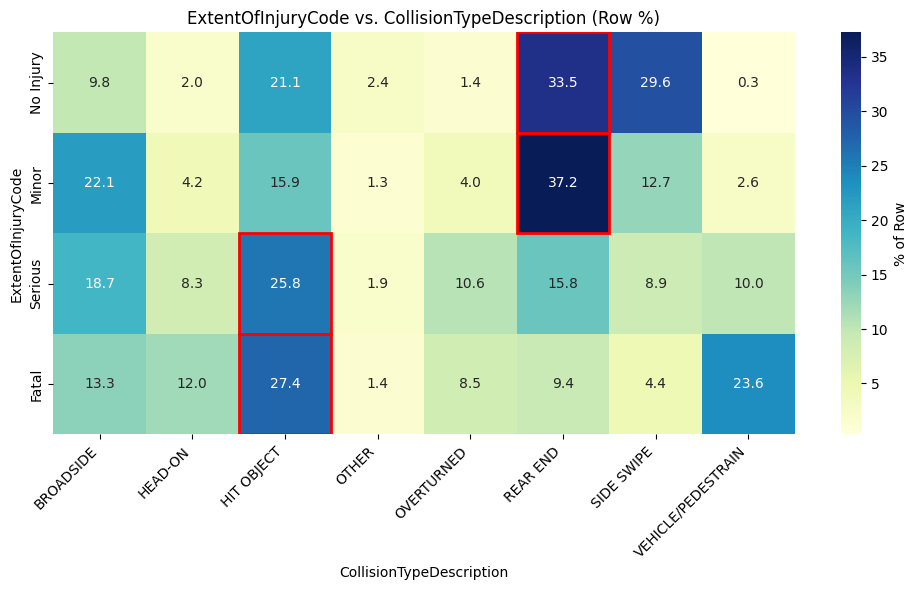

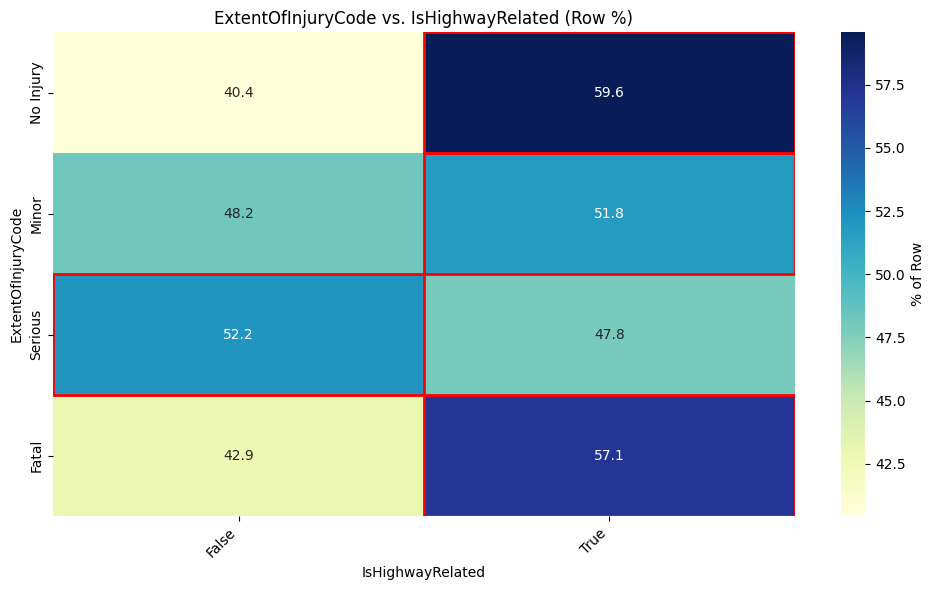

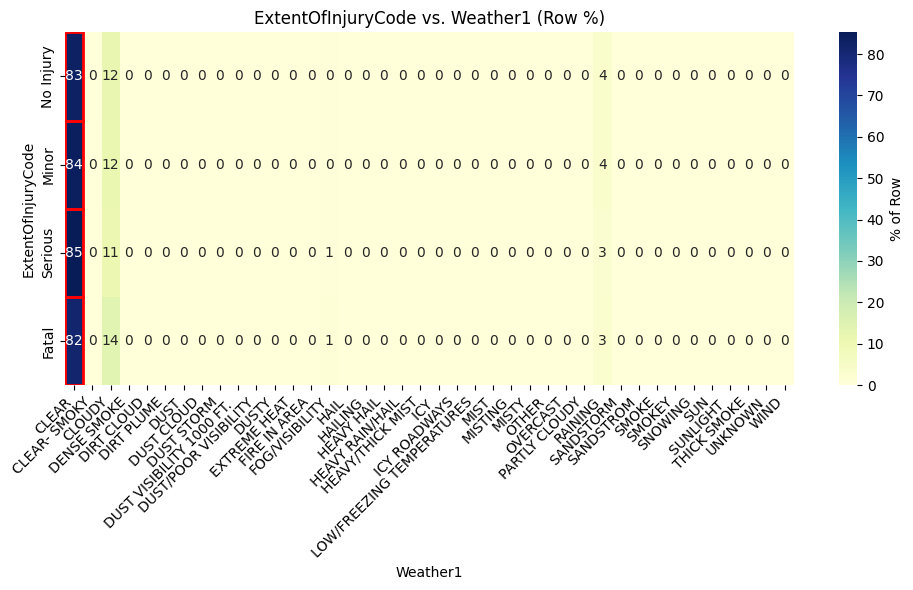

Skipping RoadCondition1 (too many categories)


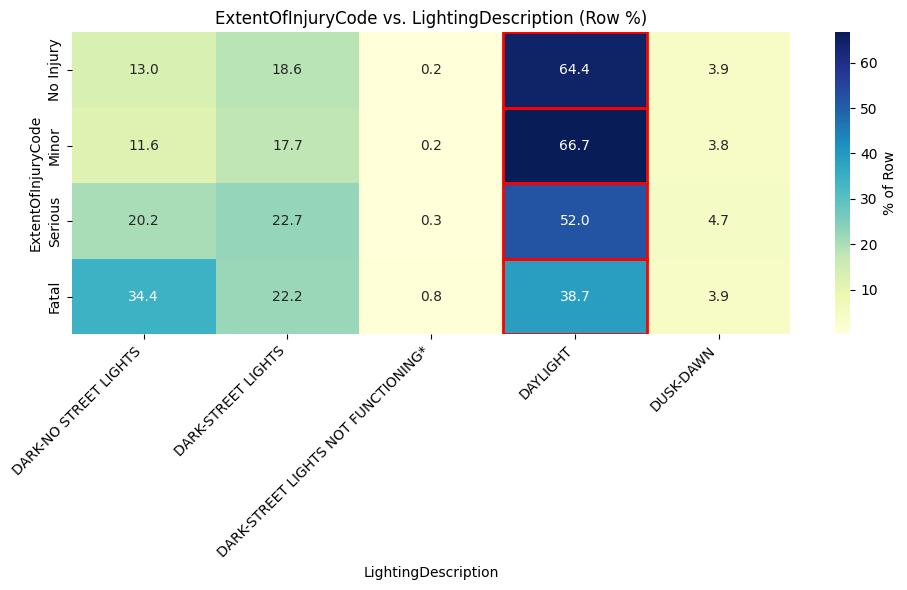

Skipping MovementPrecCollDescription (too many categories)
Skipping AirbagDescription (too many categories)
Skipping SafetyEquipmentDescription (too many categories)
Skipping SobrietyDrugPhysicalDescription1 (too many categories)
Skipping SpecialInformation (too many categories)


In [59]:
# Print shape of data
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

# Print unique values of variables
columns = train_df.columns
print(columns)

# Separate numerical and categorical features (inputs)
num_features = ['SpeedLimit']
cat_features = ['CollisionTypeDescription', 'IsHighwayRelated',
                'Weather1', 'RoadCondition1', 'LightingDescription',
                'MovementPrecCollDescription',
                'AirbagDescription', 'SafetyEquipmentDescription',
                'SobrietyDrugPhysicalDescription1', 'SpecialInformation']

# Create a heatmap from crosstabs for each categorical feature and the output variable
for cf in cat_features:
  table = pd.crosstab(train_df['ExtentOfInjuryCode'], train_df[cf])

  # Only plot variables that have less than 40 unique values
  if table.shape[0] > 40 or table.shape[1] > 40:
    print(f"Skipping {cf} (too many categories)")
    continue

  # Normalize rows to percentages
  row_percent = table.div(table.sum(axis=1), axis=0) * 100

  # Plot heatmap
  plt.figure(figsize=(10, 6))
  if cf == 'Weather1':
    # remove decimals for weather for readibility
    ax = sns.heatmap(row_percent, cmap="YlGnBu", annot=True, fmt='.0f', cbar_kws={'label': '% of Row'})
  else:
    ax = sns.heatmap(row_percent, cmap="YlGnBu", annot=True, fmt='.1f', cbar_kws={'label': '% of Row'})

  for y, row in enumerate(row_percent.values):   # Highlight max per row (extent of injury)
      x = row.argmax()
      ax.add_patch(plt.Rectangle((x, y), 1, 1, fill=False, edgecolor='red', lw=2))

  plt.title(f"ExtentOfInjuryCode vs. {cf} (Row %)")
  plt.xlabel(cf)
  plt.ylabel("ExtentOfInjuryCode")
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()


#for col in columns:
#  print(f"\nUnique values of {col}: {train_df[col].unique()}")


Due to limitation in the prior iteration of plots for variables in list, below are the plots for these listed variables.

*Please note that the total count will not equal the total number of samples since there are several samples will multiple values. The total count will vary across each resulting plot for the list-style features below.*

In [63]:
# Separate categorical features into groups based on whether its a list or not
clear_vars = [
    'CollisionTypeDescription', 'IsHighwayRelated',
    'Weather1', 'RoadCondition1', 'LightingDescription'
]

list_style_vars = [
    'MovementPrecCollDescription', 'AirbagDescription',
    'SafetyEquipmentDescription', 'SobrietyDrugPhysicalDescription1',
    'SpecialInformation'
]

all_vars = clear_vars + list_style_vars # combine into a single variable

train_df['ExtentOfInjuryCode'] = pd.Categorical(
    train_df['ExtentOfInjuryCode'],
    categories=injury_order,
    ordered=True
)

# Iterate through all input variables
for col in all_vars:
    # 1 - Initialize a dictionary to hold (category, injury extent) pairs
    count_dict = defaultdict(Counter)

    # 2 - Iterate through feature values and output values to gather counts
    # Logic for list-style vars
    if col in list_style_vars:
        for _, row in train_df[[col, 'ExtentOfInjuryCode']].iterrows():
            val = row[col]
            injury = row['ExtentOfInjuryCode']

            if pd.isna(val) or pd.isna(injury):
                continue

            try:
                parsed = ast.literal_eval(val)
            except (ValueError, SyntaxError):
                continue

            if isinstance(parsed, list):
                for v in parsed:
                    if isinstance(v, (str, int, float)):
                        count_dict[v][injury] += 1
            elif isinstance(parsed, (str, int, float)):
                count_dict[parsed][injury] += 1

    # Logic for normal (clear) vars
    else:
        for _, row in train_df[[col, 'ExtentOfInjuryCode']].iterrows():
            values = row[col]
            injury = row['ExtentOfInjuryCode']

            if isinstance(values, list):
                for val in values:
                    if isinstance(val, (str, int, float)):
                        count_dict[val][injury] += 1
            elif isinstance(values, (str, int, float)):
                count_dict[values][injury] += 1


    # Get top 10 most common categories
    total_counts = {k: sum(v.values()) for k, v in count_dict.items()}
    top_10 = sorted(total_counts, key=total_counts.get, reverse=True)[:10]

    # Prepare DataFrame
    chart_data = []
    for cat in top_10:
        for injury, count in count_dict[cat].items():
            chart_data.append({
                'Category': cat,
                'ExtentOfInjuryCode': injury,
                'Count': count
            })


    df_chart = pd.DataFrame(chart_data)
    df_chart['ExtentOfInjuryCode'] = pd.Categorical(
        df_chart['ExtentOfInjuryCode'],
        categories=injury_order,
        ordered=True
      )

    # Plot
    base = alt.Chart(df_chart).encode(
        x=alt.X('Category:N', sort='-y'),
        y='Count:Q',
        color=alt.Color('ExtentOfInjuryCode:N', sort=injury_order)
    )

    final_chart = (base.mark_bar() + base.mark_text(
        align='left',
        baseline='bottom',
        dx=10,
        fontSize=10,
        angle=270
    ).encode(
        text=alt.Text('Count:Q')
    )).facet(
        column=alt.Column('ExtentOfInjuryCode:N',
                          sort=injury_order,
                          header=alt.Header(labelAngle=0))
    ).properties(
        title=f"'{col}' by Extent of Injury (Top 10 Categories)"
    )

    final_chart.display()

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

alt.FacetChart(...)

And finally we can run a simple boxplot on our single numeric feature, speed limit. Keep in mind this is the normalize speed limit which is why the mean is at 0.

In [56]:
alt.Chart(train_df).mark_boxplot(extent='min-max').encode(
    y=alt.Y('ExtentOfInjuryCode:N', sort=injury_order, title='Extent of Injury'),
    x=alt.X('SpeedLimit:Q', title='Speed Limit'),
    color=alt.Color('ExtentOfInjuryCode:N', sort=injury_order)
).properties(
    title='Speed Limit Distribution by Extent of Injury'
)

alt.Chart(...)

## 5. Encode *categorical* variables with one-hot encoding
#### (A suggestion)

In [118]:
label_maps = {}

for col in categorical_vars:
    print(f"Processing: {col}")

    # Step 1: Drop NaNs and convert to string
    raw_vals = train_df[col].dropna().astype(str).tolist()

    # Step 2: Split by ',' and strip whitespace
    split_vals = [item.strip() for row in raw_vals for item in row.split(',')]

    # Step 3: Deduplicate and sort
    unique_labels = sorted(set(split_vals))

    # Step 4: Create label-to-index mapping
    label_maps[col] = {label: idx for idx, label in enumerate(unique_labels)}

    print(f"  → Found {len(unique_labels)} unique labels in '{col}'")

Processing: CollisionTypeDescription
  → Found 8 unique labels in 'CollisionTypeDescription'
Processing: IsHighwayRelated
  → Found 2 unique labels in 'IsHighwayRelated'
Processing: Weather1
  → Found 40 unique labels in 'Weather1'
Processing: RoadCondition1
  → Found 333 unique labels in 'RoadCondition1'
Processing: LightingDescription
  → Found 5 unique labels in 'LightingDescription'
Processing: ExtentOfInjuryCode
  → Found 4 unique labels in 'ExtentOfInjuryCode'
Processing: MovementPrecCollDescription
  → Found 76 unique labels in 'MovementPrecCollDescription'
Processing: AirbagDescription
  → Found 20 unique labels in 'AirbagDescription'
Processing: SafetyEquipmentDescription
  → Found 78 unique labels in 'SafetyEquipmentDescription'
Processing: SobrietyDrugPhysicalDescription1
  → Found 34 unique labels in 'SobrietyDrugPhysicalDescription1'
Processing: SpecialInformation
  → Found 44 unique labels in 'SpecialInformation'


In [119]:
print(label_maps)

{'CollisionTypeDescription': {'BROADSIDE': 0, 'HEAD-ON': 1, 'HIT OBJECT': 2, 'OTHER': 3, 'OVERTURNED': 4, 'REAR END': 5, 'SIDE SWIPE': 6, 'VEHICLE/PEDESTRAIN': 7}, 'IsHighwayRelated': {'False': 0, 'True': 1}, 'Weather1': {'CLEAR': 0, 'CLEAR- SMOKY': 1, 'CLOUDY': 2, 'DENSE SMOKE': 3, 'DIRT CLOUD': 4, 'DIRT PLUME': 5, 'DUST': 6, 'DUST CLOUD': 7, 'DUST STORM': 8, 'DUST VISIBILITY 1000 FT.': 9, 'DUST/POOR VISIBILITY': 10, 'DUSTY': 11, 'EXTREME HEAT': 12, 'FIRE IN AREA': 13, 'FOG/VISIBILITY': 14, 'HAIL': 15, 'HAILING': 16, 'HEAVY HAIL': 17, 'HEAVY RAIN/HAIL': 18, 'HEAVY/THICK MIST': 19, 'ICY': 20, 'ICY ROADWAYS': 21, 'LOW/FREEZING TEMPERATURES': 22, 'MIST': 23, 'MISTING': 24, 'MISTY': 25, 'OTHER': 26, 'OVERCAST': 27, 'PARTLY CLOUDY': 28, 'RAINING': 29, 'SANDSTORM': 30, 'SANDSTROM': 31, 'SMOKE': 32, 'SMOKEY': 33, 'SNOWING': 34, 'SUN': 35, 'SUNLIGHT': 36, 'THICK SMOKE': 37, 'UNKNOWN': 38, 'WIND': 39}, 'RoadCondition1': {'': 0, 'CONSTRUCTION-REPAIR ZONE': 1, 'CONSTRUCTION-REPAIR ZONE - CONSTRU

In [122]:
def encode_row(row, label_map):
    if pd.isna(row):
        return []
    if isinstance(row, list):
        return [label_map[label] for label in row if label in label_map]
    if isinstance(row, str):
        return [label_map[label.strip()] for label in row.split(',') if label.strip() in label_map]
    return []

for df in [train_df, val_df, test_df]:
    for col in categorical_vars:
        df[col + '_encoded'] = df[col].apply(lambda x: encode_row(x, label_maps[col]))